In [37]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

In [38]:
x_data = np.float64(np.linspace(-15, 15, 500))
y_data = np.float64(np.sin(x_data) / x_data)

In [39]:
dataset = Dataset(x_data, y_data)

intersize, testsize = 50, 30
interset, trainset, testset = torch.utils.data.random_split(dataset, [intersize, len(dataset)-intersize-testsize, testsize], generator=torch.Generator().manual_seed(42)) # 0.1=3000

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

activation = nn.Sigmoid()

In [40]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x

model = ELM(1, 50, 1)

In [41]:
H = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ interset[:][0].reshape(1, -1)).T
Y = interset[:][1].reshape(1, -1).T
W2 = torch.linalg.pinv(H) @ Y.reshape(1, -1, 1)
model.fc2.weight.data = W2[0].T

In [42]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-10)

Epoch: [1/100], loss: 0.000016
Epoch: [2/100], loss: 0.000016
Epoch: [3/100], loss: 0.000005
Epoch: [4/100], loss: 0.000003
Epoch: [5/100], loss: 0.000022
Epoch: [6/100], loss: 0.000006
Epoch: [7/100], loss: 0.000010
Epoch: [8/100], loss: 0.000015
Epoch: [9/100], loss: 0.000013
Epoch: [10/100], loss: 0.000020
Epoch: [11/100], loss: 0.000003
Epoch: [12/100], loss: 0.000004
Epoch: [13/100], loss: 0.000015
Epoch: [14/100], loss: 0.000016
Epoch: [15/100], loss: 0.000003
Epoch: [16/100], loss: 0.000003
Epoch: [17/100], loss: 0.000009
Epoch: [18/100], loss: 0.000014
Epoch: [19/100], loss: 0.000018
Epoch: [20/100], loss: 0.000005
Epoch: [21/100], loss: 0.000004
Epoch: [22/100], loss: 0.000013
Epoch: [23/100], loss: 0.000002
Epoch: [24/100], loss: 0.000014
Epoch: [25/100], loss: 0.000006
Epoch: [26/100], loss: 0.000018
Epoch: [27/100], loss: 0.000006
Epoch: [28/100], loss: 0.000004
Epoch: [29/100], loss: 0.000001
Epoch: [30/100], loss: 0.000014
Epoch: [31/100], loss: 0.000004
Epoch: [32/100], 

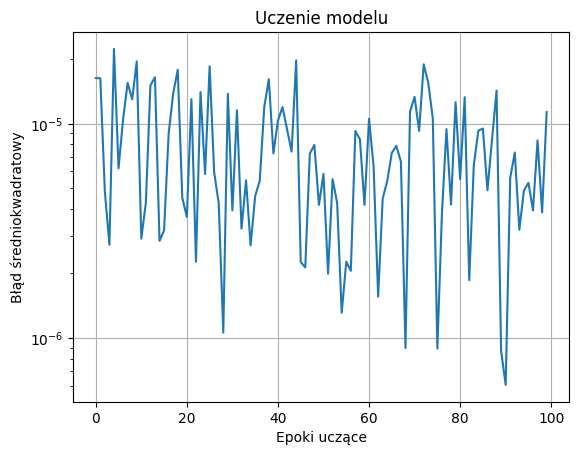

In [43]:
num_epochs = 100
all_losses = []
model.train()

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        x, y = x.reshape(-1, 1), y.reshape(-1, 1)
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
    all_losses.append(loss.item())
    print(f'Epoch: [{epoch+1}/{num_epochs}], loss: {loss.item():.6f}')

plt.plot(all_losses)
plt.yscale('log')
plt.title('Uczenie modelu')
plt.xlabel('Epoki uczące')
plt.ylabel('Błąd średniokwadratowy')
plt.grid()
plt.show()

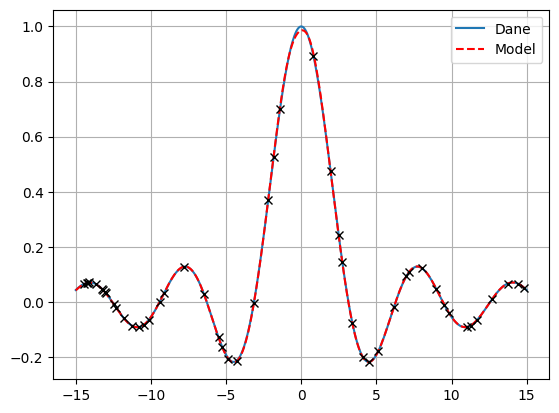

Train error: 7.494205324509308e-06
Test error: 2.3241267948316167e-05


In [44]:
plt.plot(x_data, y_data)
plt.plot(x_data, model(torch.tensor(x_data).reshape(-1, 1)).detach().numpy(), 'r--')
plt.plot(interset[:][0], interset[:][1], 'kx')
plt.legend(['Dane', 'Model'], loc='upper right')
plt.grid()
plt.show()
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 1))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 1))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')

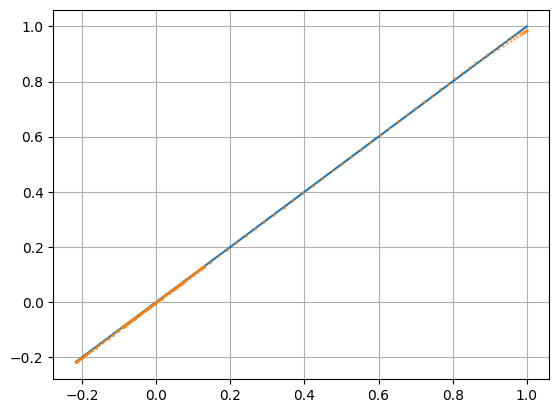

In [45]:
plt.plot([np.min(y_data), np.max(y_data)], [np.min(y_data), np.max(y_data)])
plt.plot(y_data, model(torch.tensor(x_data).reshape(-1, 1)).detach().numpy(), '.', markersize=1)
plt.grid()
plt.show()